<a href="https://colab.research.google.com/github/sametgirgin/Python-Projects/blob/main/YE_ile_%C5%9Eebeke_Optimizasyonu_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Makine Öğrenimi Algoritmalarıyla Şebeke Talep & Üretim Tahmini, Optimizasyonu ve Çevre-Ekonomik Etki Değerlendirmesi:**

Akıllı şehir, kamu hizmetlerini iyileştirmek, kentsel zorluklara çözüm bulmak ve sakinlerinin yaşam kalitesini artırmak için teknoloji ve verileri kullanan bir şehirdir.

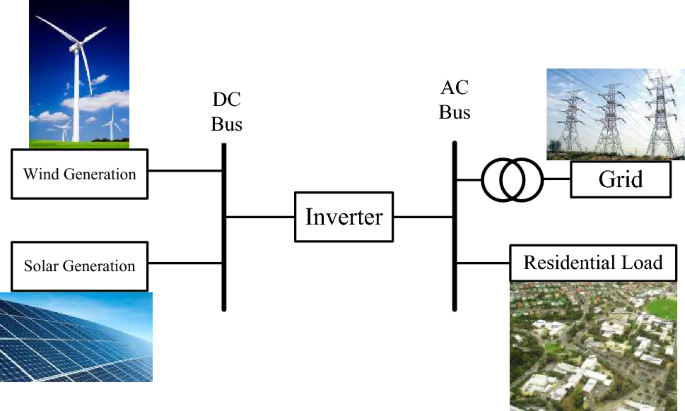

**Bu, trafik akışını optimize etmek, enerji kullanımını yönetmek, kamu güvenliğini artırmak ve daha fazlasını yapmak için sensörlerin ve veri analitiğinin kullanılmasını içerebilir**

Bu çalışma, enerji modellerini belirlemek, talebi ve yenilenebilir üretimi tahmin etmek ve güvenilir şebeke yönetimi için optimizasyon stratejileri tasarlamak amacıyla geçmiş veri analizi için Python ve ML kütüphanelerinin kullanımına dayanır.

Amaç, hem çevresel hem de ekonomik etkileri değerlendirerek yenilenebilir enerji kullanımını en üst düzeye çıkarırken şebeke istikrarını iyileştirmektir.

**Adımlar ve Çıktılar**:

1-Veri Analizi:

- Veriler talep ve arzdaki desenleri (patern) bulmak için analiz edilir. (Güneş ve rüzgardaki reliability ve variability önemli)

- Hava durumu ve yenilenebilir enerji kaynakları arasındaki korelasyona bakılır

2- Tahminleme:

- Geçmiş hava durumu verilerine dayanarak güneş ve rüzgar enerjisi üretimini tahmin edilir. Model performansını değerlendirmek için RMSE (Root Mean Square Error) kullanılır.

- Gelecek 7 günü tahminleyen bir ML modeli oluşturulur

3- Optimizasyon Stratejisi:

- Üretilen elektrik maliyetini minimize eden bir optimazasyon sorusuna  çözüm aranır.

4- Etki değerlendirmesi:

- Optimizasyon stratejisiyle elde edilecek karbon emisyonlarındaki azalma ölçülür. (Doğal gaz için 0,5 kg CO2/kWh).

- Pik yük enerji santrallerine (gaz vb) olan bağımlılığın azalması ve yenilenebilir enerji kullanımının artmasıyla elde edilen tasarrufları hesaplayarak ekonomik etki değerlendirilir.


Varsayılan Maliyetler:

  - Güneş enerjisi için 0,05 $/kWh

  - Rüzgar için 0,07 $/kWh

  - Doğal gaz için 0,15 $/kWh


In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 24.0 MB/s eta 0:00:00


Veri analizi, veri görselleştirme, makine öğrenimi modeli, zaman serisi analizi, model değerlendirme ve optimizasyon için kullanılacak Python kütüphaneleri import edilir.

Github repodan iki adet veriseti çekilir.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pulp
# Veri kümeleri yüklenir

weather_data = pd.read_csv("https://raw.githubusercontent.com/sametgirgin/Hibrit-Enerji-Sistemi/main/WeatherData.csv")
energy_data = pd.read_csv("https://raw.githubusercontent.com/sametgirgin/Hibrit-Enerji-Sistemi/main/EnergyData.csv")

In [3]:
# Veri tablolarına ön gözlem
print(energy_data.head())
print(weather_data.head())

       Date  Hour  Demand_MW  Solar_MW    Wind_MW
0  1/1/2023     0  85.488436       0.0  16.640621
1  1/1/2023     1  85.212058       0.0  16.452806
2  1/1/2023     2  85.662402       0.0  16.452806
3  1/1/2023     3  86.015495       0.0  16.596152
4  1/1/2023     4  88.713942       0.0  16.855640
         Date  AvgTemp_Celsius  SunlightHours  AvgWindSpeed_kmh
0  2023-01-01        12.760438       9.191722         18.239061
1  2023-01-01        12.760438       9.191722         18.239061
2  2023-01-01        12.760438       9.191722         18.239061
3  2023-01-01        12.760438       9.191722         18.239061
4  2023-01-01        12.760438       9.191722         18.239061


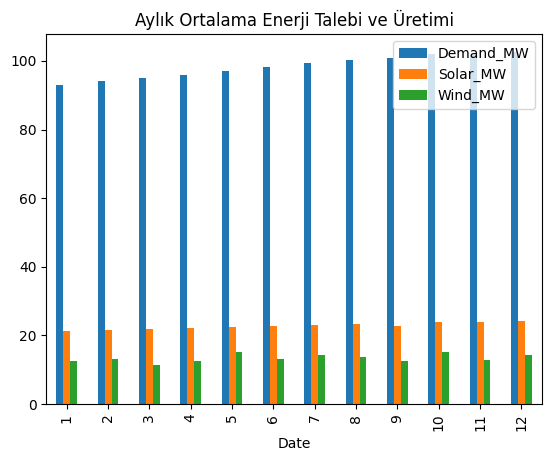

In [4]:
# Aylık enerji talebi ve üretimlerinin ortalamaları
energy_data["Date"] = pd.to_datetime(energy_data["Date"])
energy_data.set_index('Date', inplace=True)
energy_data.groupby(energy_data.index.month).mean().plot(kind='bar', y=['Demand_MW', 'Solar_MW', 'Wind_MW'])
plt.title('Aylık Ortalama Enerji Talebi ve Üretimi')
plt.show()

Verisetlerinin birleşitirilmesi ve Korelasyon Analizi

<Axes: >

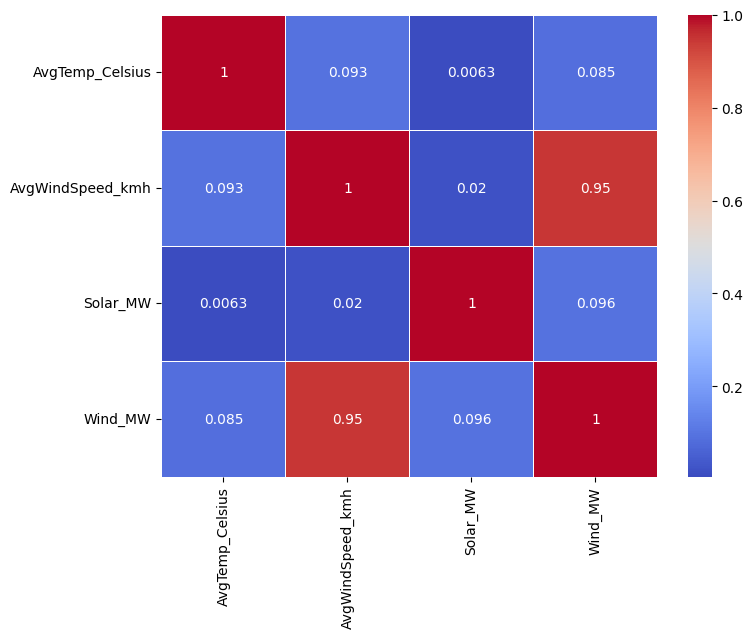

In [5]:
# Birleştirme işlemi için indeks silme
energy_data.reset_index(inplace=True)
# Tarih sütunları Datetime formatında
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
# İki veris seti tarihlerden birleştirildi
merged_data = pd.merge(energy_data, weather_data, on='Date')
# Güneşte bazı günler 0 alınıdığı için bunlar filtrelenir.
merged_data = merged_data[merged_data['Solar_MW'] > 0]

# Enerji üretimi ve hava durumu korelasyonu
correlation = merged_data[['AvgTemp_Celsius', 'AvgWindSpeed_kmh','Solar_MW', 'Wind_MW']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=.5)

**Güç Üretim ve Talebini Tahmini**

RMSE (Kök Ortalama Kare Hata), modelimizin tahminlerinin doğruluğunun bir ölçüsünü verir. Spesifik olarak, tahmin edilen değerler ile gözlemlenen gerçek değerler arasındaki hataların ortalama büyüklüğünü ölçer.

RMSE'yi Anlamak:

- Hataların Büyüklüğü: RMSE, tahmin edilen değerler ile gerçek değerler arasındaki kare farkların ortalamasının karekökünü temsil eder. Daha düşük RMSE değerleri daha iyi uyumu ve daha doğru tahminleri gösterir.

- Aykırı Değerlere Duyarlılık: Hataların ortalaması alınmadan önce kareleri alındığından, RMSE büyük hatalara nispeten yüksek bir ağırlık verir. Bu, RMSE'nin aykırı değerlere duyarlı olduğu anlamına gelir.


https://en.wikipedia.org/wiki/Root_mean_square_deviation
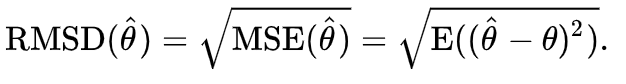


**Random Forest Regressor ile ilgili bilgi:**

https://towardsdatascience.com/random-forest-regression-5f605132d19d

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [8]:
# Tahmin kurulumu (y Hedef değişkenler, X öznitelikler)
X = merged_data[['AvgTemp_Celsius', 'AvgWindSpeed_kmh']]
y_talep = merged_data['Demand_MW']
y_gunes = merged_data['Solar_MW']
y_ruzgar = merged_data['Wind_MW']

# Güç Talebi için eğitim ve test verisi oluşturma, model eğitme ve tahminleme
X_train, X_test, y_train, y_test = train_test_split(X, y_talep, test_size=0.2, random_state = 42)
talep_model = RandomForestRegressor(random_state=42)
talep_model.fit(X_train, y_train)
y_talep_tahmin = talep_model.predict(X_test)

# Güneş ve rüzgar modeli kurulumu- Rüzgar ve güneş için iki ayrı model örneği oluşturulur.
gunes_model = RandomForestRegressor(random_state=42)
ruzgar_model = RandomForestRegressor(random_state=42)

# Sıfır güneş enerjisi üretimini filtreledikten sonra endekslerin hizalanması gereklidir
X = X.reset_index(drop=True)
y_gunes = y_gunes.reset_index(drop=True)
y_ruzgar = y_ruzgar.reset_index(drop=True)

# Güneş ve rüzgar gücü için eğitim ve test verisi oluşturma, model eğitme ve tahminleme
X_train_gunes, X_test_gunes, y_train_gunes, y_test_gunes =  train_test_split(X, y_gunes, test_size=0.2, random_state=42)
X_train_ruzgar, X_test_ruzgar, y_train_ruzgar, y_test_ruzgar = train_test_split(X, y_ruzgar, test_size=0.2, random_state=42)
gunes_model.fit(X_train_gunes, y_train_gunes)
ruzgar_model.fit(X_train_ruzgar, y_train_ruzgar)
y_gunes_tahmin = gunes_model.predict(X_test_gunes)
y_ruzgar_tahmin = ruzgar_model.predict(X_test_ruzgar)

# Gerçek değeri sıfır olan tahmin değerlerini düzeltmek için sıfır değeri girilir.
actual_zeros = energy_data[energy_data['Solar_MW']== 0].index
mask_zeros_in_actuals = X_test_gunes.index.isin(actual_zeros)
y_gunes_tahmin_corrected = np.where(mask_zeros_in_actuals, 0, y_gunes_tahmin)

#Model değerlendirme süreci
# Gerçek ve tahmini değerlerden elde edilen RMSE değerini tanımlayan fonksiyorn yazılır.
def rmse_percentage(true_values, predicted_values):
  rmse = sqrt(mean_squared_error(true_values, predicted_values))
  average = np.mean(true_values)
  return (rmse / average)*100

# Enerji Talebi, güneş ve rüzgar enerji üretimleri için RMSE hesabu
talep_rmse = rmse_percentage (y_test, y_talep_tahmin)
gunes_rmse = rmse_percentage (y_test_gunes, y_gunes_tahmin)
ruzgar_rmse = rmse_percentage (y_test_ruzgar, y_ruzgar_tahmin)

# RMSE yüzdesi çıktıları
print (f"Talep Tahmini RMSE (%): {talep_rmse}")
print (f"Güneş Üretim Tahmini RMSE (%): {gunes_rmse}")
print(f"Rüzgar Üretim Tahmini RMSE (%): {ruzgar_rmse}")

Talep Tahmini RMSE (%): 5.943996634938721
Güneş Üretim Tahmini RMSE (%): 9.011440280631595
Rüzgar Üretim Tahmini RMSE (%): 8.31763762351461


Tahmin edilen değerlerin ve Gerçek Değerlerin Görselleştirilmesi:

- Modelin enerji gereksinimlerini, güneş ve rüzgar üretimlerini tahminde doğruluğunu (accuracy) anlamak

- (Solar için) Bu grafikler, modelin güneş ışığı mevcudiyeti ve hava koşulları gibi faktörlerden etkilenen güneş enerjisi üretimindeki doğal değişkenliği ele alma yeteneğini değerlendirmek için önemlidir.


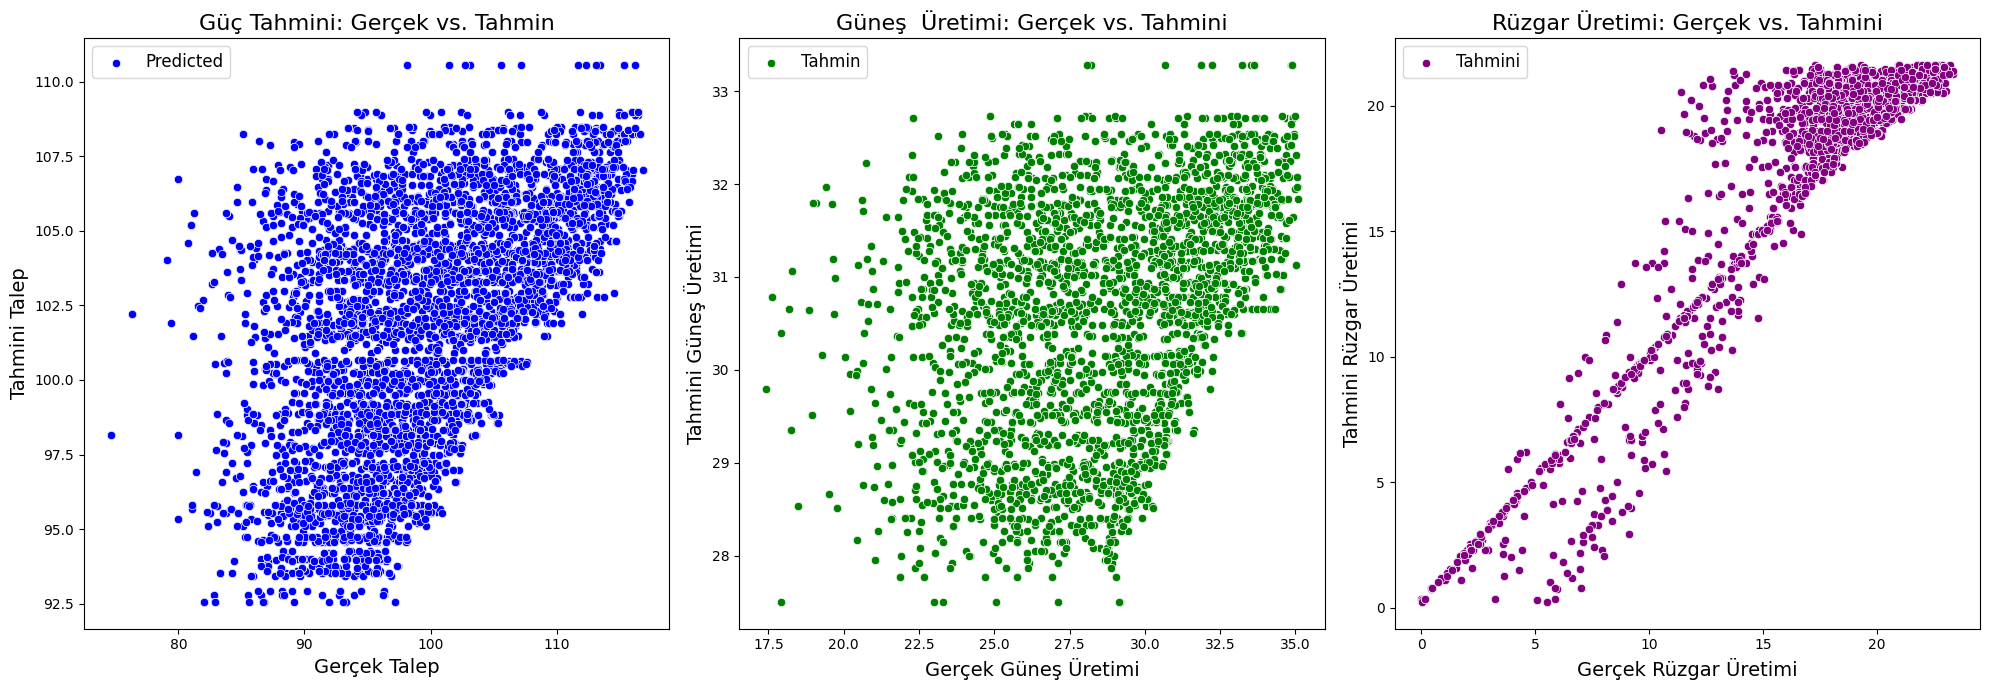

In [9]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Enerji talep görselleştirmesi
sns.scatterplot(x=y_test, y=y_talep_tahmin, color='blue', label='Predicted', ax=axes[0])
axes[0].set_title('Güç Tahmini: Gerçek vs. Tahmin', fontsize=16)
axes[0].set_xlabel('Gerçek Talep', fontsize=14)
axes[0].set_ylabel('Tahmini Talep', fontsize=14)
axes[0].legend(fontsize=12)

# Güneş enerji üretimi görselleştirmesi
sns.scatterplot(x=y_test_gunes, y=y_gunes_tahmin, color='green', label='Tahmin', ax=axes[1])
axes[1].set_title('Güneş  Üretimi: Gerçek vs. Tahmini', fontsize=16)
axes[1].set_xlabel('Gerçek Güneş Üretimi', fontsize=14)
axes[1].set_ylabel('Tahmini Güneş Üretimi', fontsize=14)
axes[1].legend(fontsize=12)

# Rüzgar enerji üretimi görselleştirmesi
sns.scatterplot(x=y_test_ruzgar, y=y_ruzgar_tahmin, color='purple', label='Tahmini', ax=axes[2])
axes[2].set_title('Rüzgar Üretimi: Gerçek vs. Tahmini', fontsize=16)
axes[2].set_xlabel('Gerçek Rüzgar Üretimi', fontsize=14)
axes[2].set_ylabel('Tahmini Rüzgar Üretimi', fontsize=14)
axes[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

**SARIMAX ile Günlük Enerji Tahmini**


- Bu bölüm günlük enerji tahmini için SARIMAX (Seasonal AutoRegressive Integrated Moving Average) modelini kullanır.

- SARIMAX zaman serilerinde hem mevsimsel hem de mevsimsel olmayan bileşenleri modelleyebilir. Bu sayade daha kompleks patternlar yakalanabilir ve enerji yönetiminde önemli olan tahminin doğruluğu daha iyi sağlanmış olur.  


https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html


- energy_data zaman serisi analizine hazırlamak için günlük bir zaman serisine dönüştürülür. (Günlük ortalama hesabı)

- SARIMAX modeli, serinin hem mevsimsel olmayan hem de mevsimsel kısımları için otoregresif, fark alma ve hareketli ortalama bileşenleri de dahil olmak üzere modelin yapısını tanımlayan belirli parametrelerle (order ve seasonal_order) yapılandırılmıştır. season_order parametresi, enerji talebi verilerinde yaygın olan haftalık mevsimselliği modellemek için 7 günlük bir periyodu içerir.






In [10]:
# SARIMAX ile günlük enerji talep tahmini
energy_data_daily = energy_data.set_index('Date').resample('D').mean()
sarima_model = SARIMAX( energy_data_daily['Demand_MW'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7) )
sarima_results = sarima_model.fit(disp=False)
sarima_forecast = sarima_results.forecast(steps=7)
print("Sonraki 7 gün için SARIMAX modeli: ")
print(sarima_forecast)

Sonraki 7 gün için SARIMAX modeli: 
2024-01-01    101.253215
2024-01-02    102.083820
2024-01-03    101.868729
2024-01-04    102.082013
2024-01-05    102.392957
2024-01-06    102.757862
2024-01-07    101.833041
Freq: D, Name: predicted_mean, dtype: float64


PuLP ile Optimizasyon: (Kaynak: https://coin-or.github.io/pulp/)

Amacı ortalama günlük enerji talebini minimum maliyetle karşılamak için güneş, rüzgar ve şebeke tedariğinin en uygun birleşimini belirlemek olan bir optimizasyon problemi için, bir doğrusal programlama kütüphanesi olan PuLP kullanılabilir.

https://towardsdatascience.com/introduction-to-linear-programming-in-python-9261e7eb44b


- Tahmin sonuçlarından **ortalama güneş ve rüzgar üretimi ve talep hesabı** yapılır. Bu adım tedarik gereksinimini ve dolayısıyla optimizasyon modelinin neyi başarmayı amaçladığına ilişkin temeli belirler.

- **Karar Değişkenleri**: Modelde karar değişkenleri bulmak istediğimiz değerlerdir. Burada, sebeke_tedarik, gunes_tedarik ve rüzgar_tedarik karar değişkenleri her bir kaynaktan tedarik edilecek enerji miktarını verir.

* Güneş ve rüzgar kaynakları, çözümlerin gerçekçi olması ve tahmin edilen potansiyel enerji üretimini aşmamasını sağlamak için belirlenen ortalama üretim kapasiteleriyle sınırlıdır.

- **Amaç Fonksiyonu**: Optimizasyon probleminin ana unsurudur. Burada, hedefimiz enerji tedarik maliyetini minimize etmektir. Bu fonksiyon güneş, rüzgar ve şebekeden sağlanan (doğalgaz kaynaklı elektrik) için kWh başına maliyetleri içerir. Bu fonksiyon minimize edilerek, talebin en düşük maliyette sağlanması amaçlanmaktadır.

* **Kısıtlar**: Optimizasyon probleminin çözümünün uyması gerektiği kurallarıdır. Buradaki ana kısıtlama, güneşten, rüzgardan ve şebekeden sağlanan toplam enerjinin en azından ortalama günlük talebe eşit olmasıdır.

* **Çözüm ve Çıktı**: Her bir enerji kaynağı için optimum besleme miktarlarını çıktı olarak verir uygun bir çözüm bulamazsa kullanıcıyı uyarır.


* **Emisyon ve Ekonomik Etki Değerlendirme**:  Şebeke tedariği yerine yenilenebilir enerji kaynakları sayesinde CO2 emisyon azalımı ve ekonomik tasarruf miktarı.

In [13]:
# PuLP ile optimizasyon
ort_gunes_MWh_corrected = np.mean(y_gunes_tahmin_corrected)
ort_ruzgar_MWh = np.mean(y_ruzgar_tahmin)
ort_günlük_talep_MW = np.mean(y_talep_tahmin)

# Etki değerlendirme için sabitler
sebeke_emisyon_faktoru = 0.5
gunes_maliyeti_per_kWh = 0.05
ruzgar_maliyeti_per_kWh = 0.07
gaz_maliyeti_per_kWh = 0.15

# Optimizasyon problemini belirle
problem = pulp.LpProblem("Enerji_Optimizasyonu", pulp.LpMinimize)

# Düzeltilmiş güneş üretimi kullanımı için tedarik değişkenlerinin güncellenmesi
sebeke_tedarik = pulp.LpVariable("Şebeke_Tedarik", lowBound=0)
gunes_tedarik = pulp.LpVariable("Güneş_Tedarik", lowBound=0,upBound=ort_gunes_MWh_corrected)
ruzgar_tedarik = pulp.LpVariable("Rüzgar_Tedarik",lowBound=0, upBound=ort_ruzgar_MWh)

# Amaç Fonksiyonu
problem += (gunes_maliyeti_per_kWh * gunes_tedarik + ruzgar_maliyeti_per_kWh* ruzgar_tedarik + gaz_maliyeti_per_kWh*sebeke_tedarik, "Toplam Maliyet")
problem += (sebeke_tedarik + gunes_tedarik + ruzgar_tedarik >= ort_günlük_talep_MW,"Talep Karşılama")
problem.solve()
# Optimum tedarikte Çözüm ve Çıktı
if pulp.LpStatus[problem.status] == 'Optimal':
  print(f"Optimum şebeke tedariği: {sebeke_tedarik.varValue:.2f} MW")
  print (f"Optimum solar tedariği: {gunes_tedarik.varValue:.2f} MW")
  print(f"Optimum rüzgar tedariği: {ruzgar_tedarik.varValue:.2f} MW")
else:
  print("Optimizasyon ekonomik bir çözüm bulamadı")

# Emisyon Etki Değerlendirmesi
emisyon_azaltma_kg = (gunes_tedarik.varValue + ruzgar_tedarik.varValue) * sebeke_emisyon_faktoru
gaz_maliyeti = ort_günlük_talep_MW * gaz_maliyeti_per_kWh
optimizasyonlu_maliyet = pulp.value(problem.objective)
tasarruf = gaz_maliyeti - optimizasyonlu_maliyet

print(f"Emisyon azalımı: {emisyon_azaltma_kg:.2f} kg CO2")
print (f"Ekonomik Tasarruf: ${tasarruf:.2f}")

Optimum şebeke tedariği: 57.64 MW
Optimum solar tedariği: 29.99 MW
Optimum rüzgar tedariği: 13.63 MW
Emisyon azalımı: 21.81 kg CO2
Ekonomik Tasarruf: $4.09


**Enerji Tedarik Dağılımının ve Çevre-Ekonomik Etkilerin  Görselleştirilmesi:**



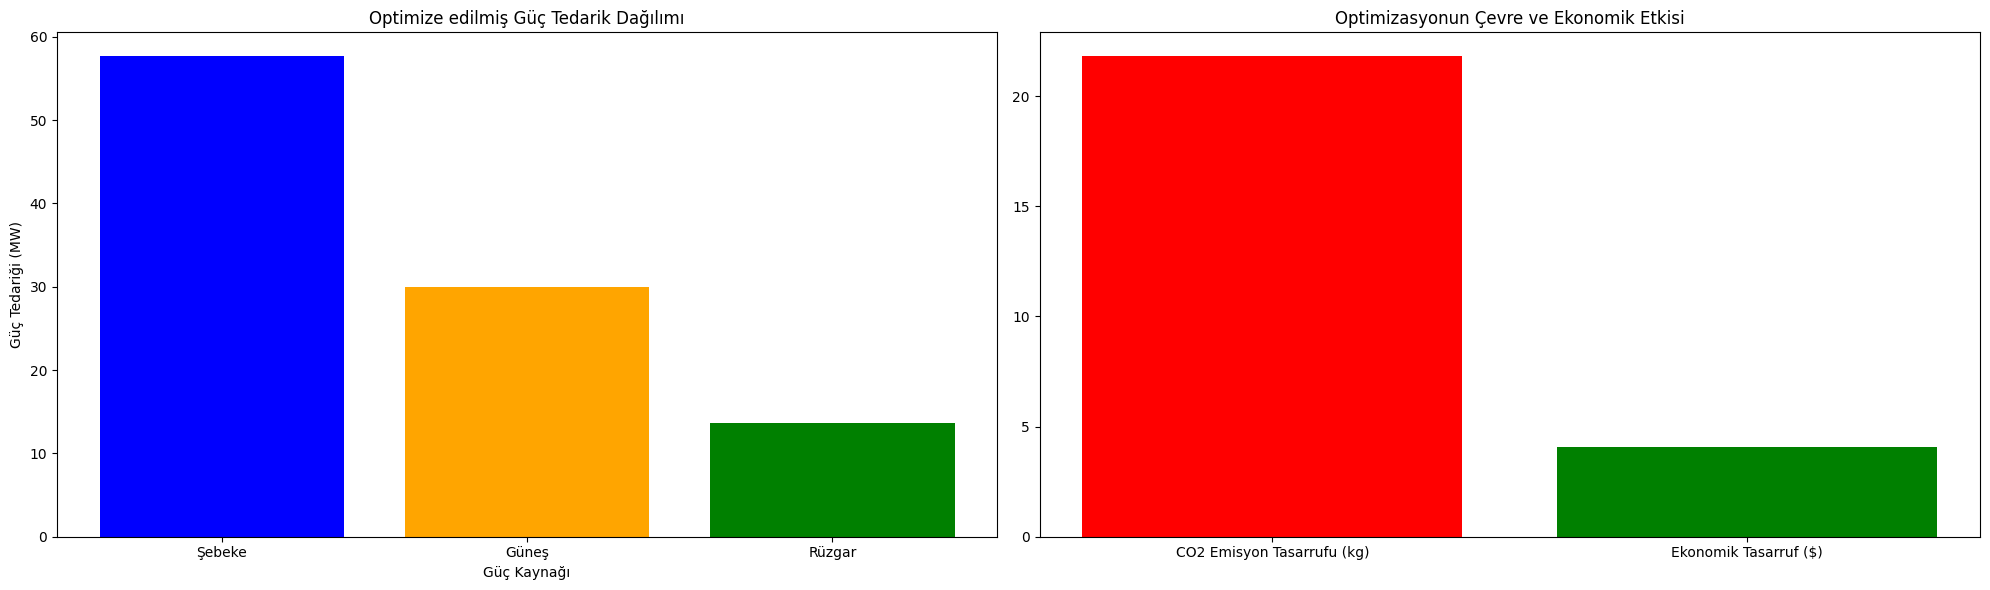

In [14]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Visualization 1: Optimized Energy Supply Distribution
axes[0].bar(['Şebeke', 'Güneş', 'Rüzgar'], [sebeke_tedarik.varValue, gunes_tedarik.varValue, ruzgar_tedarik.varValue], color=['blue', 'orange', 'green'])
axes[0].set_title('Optimize edilmiş Güç Tedarik Dağılımı')
axes[0].set_xlabel('Güç Kaynağı')
axes[0].set_ylabel('Güç Tedariği (MW)')

# Visualization 2: Environmental and Economic Impact of Optimization
axes[1].bar(['CO2 Emisyon Tasarrufu (kg)', 'Ekonomik Tasarruf ($)'], [emisyon_azaltma_kg, tasarruf], color=['red', 'green'])
axes[1].set_title('Optimizasyonun Çevre ve Ekonomik Etkisi')

plt.tight_layout()
plt.show()

**References**:


L. Zhao and M. Wei, "Optimization of Renewable Energy Supply Chains with Python," Journal of Cleaner Production, vol. 250, pp. 119-127, Jan. 2020.

 N. Grant and O. Boyd, "Evaluating Solar Irradiance Forecasting Techniques Using Python," Energy Reports, vol. 6, pp. 213-220, Jan. 2020.

R. Gupta and S. Kumar, "Python-Based Optimization for Load Forecasting in Smart Grids," Electric Power Systems Research, vol. 176, pp. 105-112, Nov. 2019.

 E. Roberts, "Python for Environmental Modeling: Applications to Wind Energy," Environmental Modelling & Software, vol. 118, pp. 112-119, Nov. 2018.

